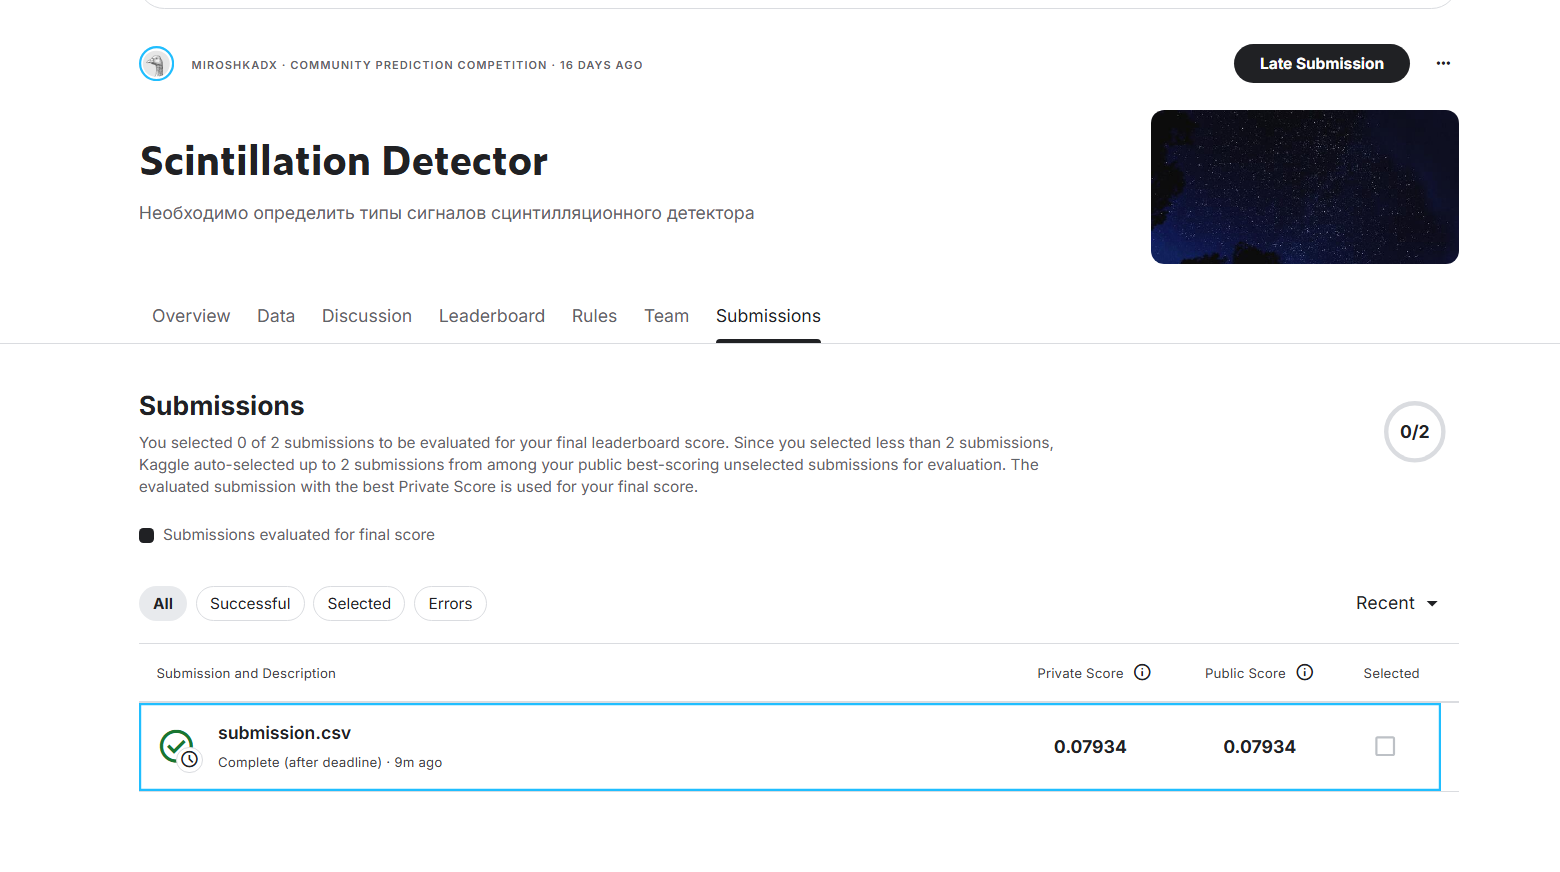

In [67]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [68]:
# Читаем исходный файл с данными
raw_data = pd.read_csv('./Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)

# Удаляем лишние колонки, которые не нужны для анализа
processed_data = raw_data.drop([0, 1, 2, 3, 504], axis=1)

# Переименовываем столбцы, чтобы они шли подряд от 0 до 499
processed_data.columns = range(500)

# Выводим первые пять строк
processed_data.head()


0      1      2      3      4      5      6      7      8      9    ...  \
0  14820  14823  14824  14822  14818  14820  14824  14822  14820  14820  ...   
1  14820  14822  14820  14826  14824  14822  14820  14822  14823  14821  ...   
2  14820  14820  14822  14825  14820  14824  14824  14819  14823  14824  ...   
3  14828  14822  14818  14824  14824  14822  14820  14822  14824  14820  ...   
4  14823  14815  14823  14821  14827  14820  14823  14824  14816  14821  ...   

     490    491    492    493    494    495    496    497    498    499  
0  14828  14822  14815  14815  14817  14819  14820  14822  14820  14819  
1  14828  14817  14824  14822  14824  14819  14820  14819  14822  14820  
2  14820  14821  14820  14820  14818  14821  14823  14820  14820  14821  
3  14824  14826  14822  14821  14820  14828  14820  14822  14823  14822  
4  14820  14820  14823  14828  14824  14820  14824  14824  14822  14825  

[5 rows x 500 columns]

Проверяем размерность загруженных временных рядов  

In [69]:
raw_data.shape

(23479, 505)

Всего в датасете 23479 сэмплов.
Посмотрим визуально на первые 50

Text(0, 0.5, 'АЦП, биты')

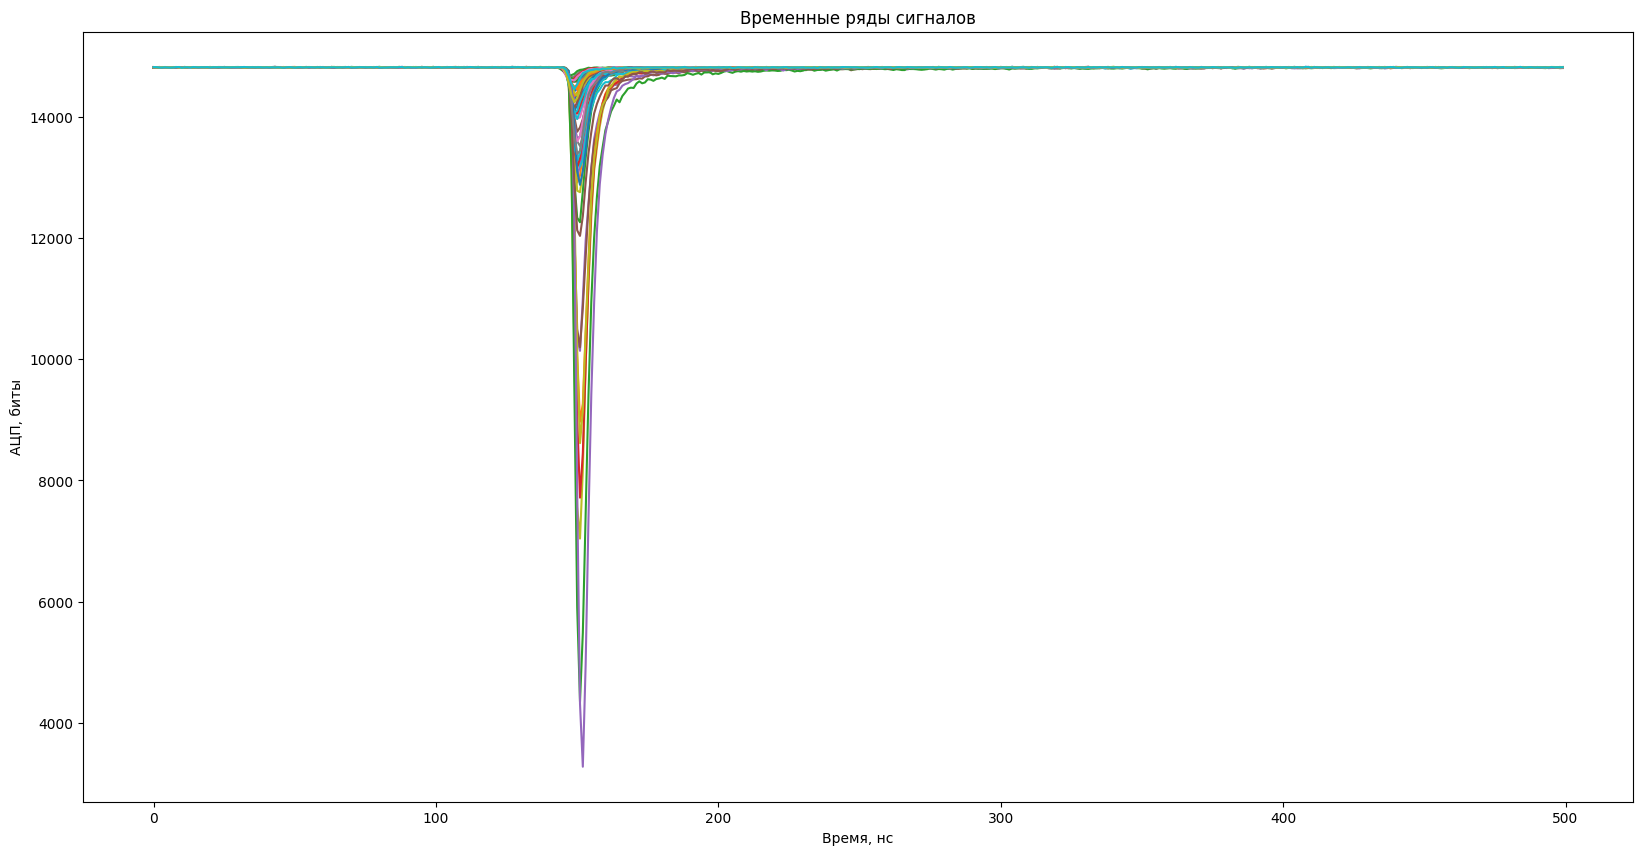

In [70]:
# Визуализируем первые 100 временных рядов
samples_range = range(0, 50)

# Строим график сигналов
plot_axis = processed_data.T[samples_range].plot(
    title='Временные ряды сигналов',
    legend=None,
    figsize=(20, 10)
)

# Настраиваем подписи осей
plot_axis.set_xlabel("Время, нс")
plot_axis.set_ylabel("АЦП, биты")

Анализ данных показывает, что полезный сигнал сосредоточен 
в диапазоне от 145 до 170 временных отсчетов

Text(0, 0.5, 'АЦП, биты')

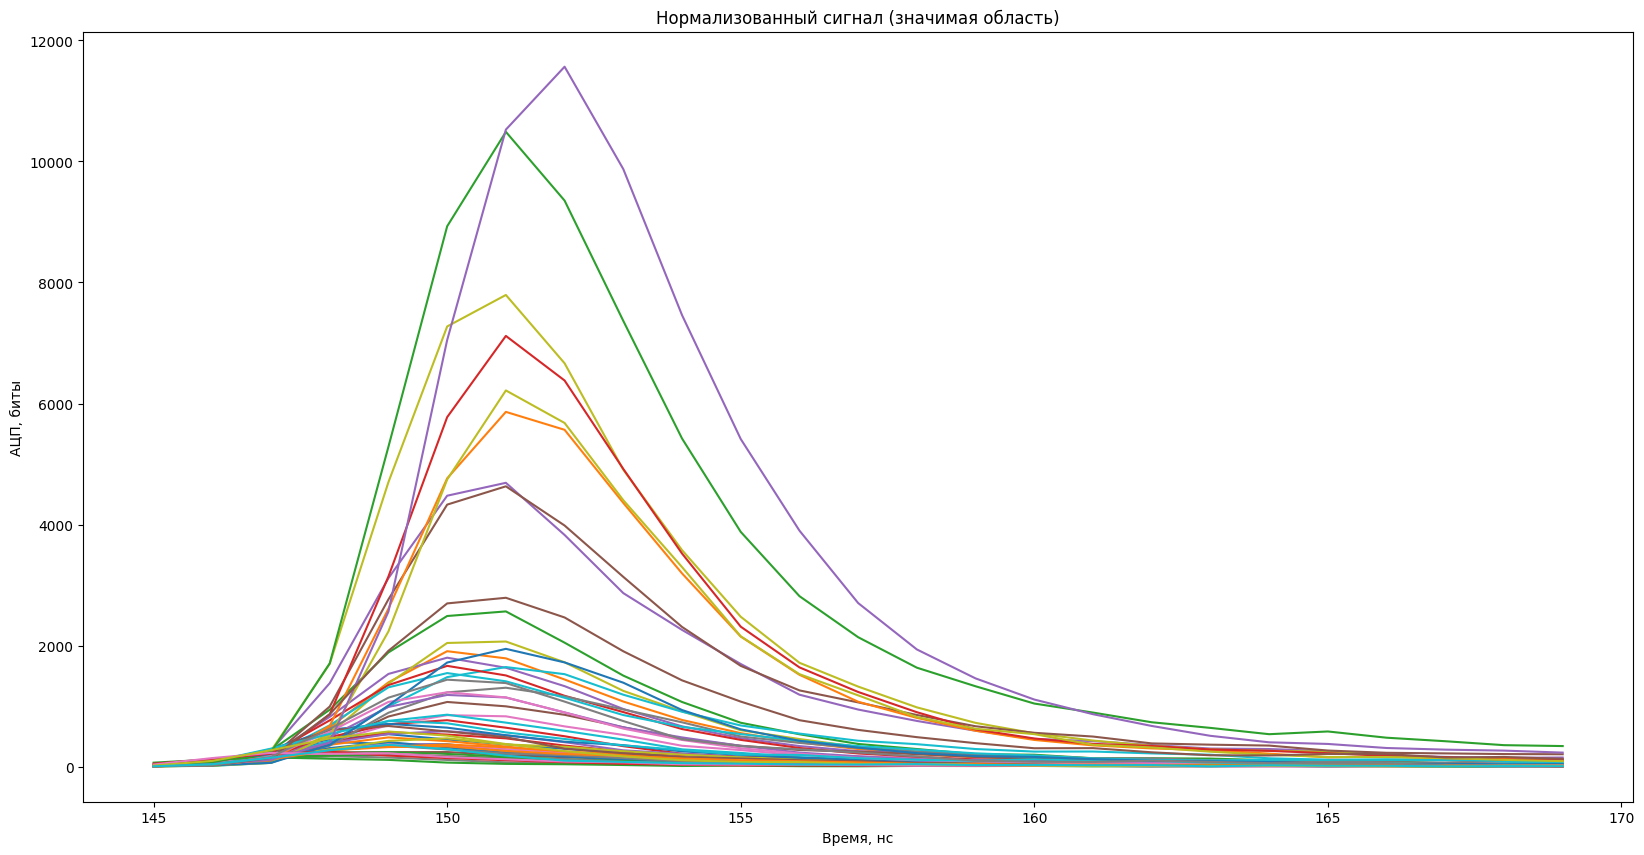

In [71]:
# Определяем значимый диапазон временных точек
significant_range = slice(145, 170)

# Выполняем преобразование данных и визуализацию
normalized_signal = (2**14 - processed_data.T[samples_range] - 1550)
plot_axis = normalized_signal[significant_range].plot(
    title='Нормализованный сигнал (значимая область)',
    legend=None,
    figsize=(20, 10)
)

# оформление графика
plot_axis.set_xlabel("Время, нс")
plot_axis.set_ylabel("АЦП, биты")

Нормализуем данные для дальнейшего анализа:
1. Инвертируем шкалу
2. Смещаем базовый уровень на 1550 единиц

In [72]:
processed_data = 2**14 - processed_data - 1550

print("первые 5 записей датафрейма:")
processed_data.head()

первые 5 записей датафрейма:


0    1    2    3    4    5    6    7    8    9    ...  490  491  492  493  \
0   14   11   10   12   16   14   10   12   14   14  ...    6   12   19   19   
1   14   12   14    8   10   12   14   12   11   13  ...    6   17   10   12   
2   14   14   12    9   14   10   10   15   11   10  ...   14   13   14   14   
3    6   12   16   10   10   12   14   12   10   14  ...   10    8   12   13   
4   11   19   11   13    7   14   11   10   18   13  ...   14   14   11    6   

   494  495  496  497  498  499  
0   17   15   14   12   14   15  
1   10   15   14   15   12   14  
2   16   13   11   14   14   13  
3   14    6   14   12   11   12  
4   10   14   10   10   12    9  

[5 rows x 500 columns]

Введем в датафрейм дополнительный признак, соответствующий максимальному уровню сигнала в каждом наблюдении.

In [73]:
# Создаем копию обработанных данных для добавления новых признаков
analysis_data = processed_data.copy()

# Добавляем столбец с максимальными значениями для каждого измерения
analysis_data['peak_value'] = analysis_data.max(axis=1)

# Выводим статистическую сводку по максимальным значениям
print("Статистика:")
analysis_data['peak_value'].describe()

Статистика:


count    23479.000000
mean      1846.138209
std       2389.308983
min        115.000000
25%        319.000000
50%        824.000000
75%       2326.000000
max      14834.000000
Name: peak_value, dtype: float64

В данных зафиксировано максимальное значение амплитуды — 14 834 единиц.

In [74]:
# Анализ записей с экстремальными значениями сигнала

PEAK_THRESHOLD = 14834  # Зафиксированное максимальное значение

# Выбираем записи с пиковыми амплитудами
peak_samples = analysis_data[analysis_data['peak_value'] == PEAK_THRESHOLD]

# Выводим первые 10 таких записей для анализа
print("Образцы сигналов с максимальной амплитудой:")
peak_samples.head(10)

Образцы сигналов с максимальной амплитудой:


0   1   2   3   4   5   6   7   8   9  ...  491  492  493  494  495  \
798    14  14  10  14  17   6  11  11  16   6  ...   12   12   14   18   10   
6401   11   8  10   9   7  11  10   7   7  10  ...   14   18   15   14   11   
9190   12  14   7  15  14  12  14  11  14  11  ...   17   14    9   14   15   
9553    7  14  16  14  11  10  12  11  10  10  ...    6   10   15   14   17   
11289  10   8  11   6  13  19   4  11  12  10  ...   14   12   16   12   10   
13595   9   6  14   7   7  10  12   7   9  10  ...   10   13   14   15   11   
17790  10  10  16   7   7   7   7   9  14  11  ...   13    7    8   10    9   
22310  10  10   7  10  14  11   7  11  10   6  ...   17   16   12   11    9   
23118   7  12  10  12  10  12  14  13  15  11  ...   10   10   12   11   12   

       496  497  498  499  peak_value  
798     14   12   16   12       14834  
6401     7   11   14   14       14834  
9190    10   12   12   14       14834  
9553    14   14   14   11       14834  
11289   17   17   14   10       14834  
13595   15    7   14   17       14834  
17790   14   13   10   10       14834  
22310   15    4   14   12       14834  
23118   10   21   18   25       14834  

[9 rows x 501 columns]

Найдено всего 9 строк, достигающих этого порогового значения. Сохраняем индексы отобранных записей для последующего анализа.

Text(0, 0.5, 'АЦП, биты')

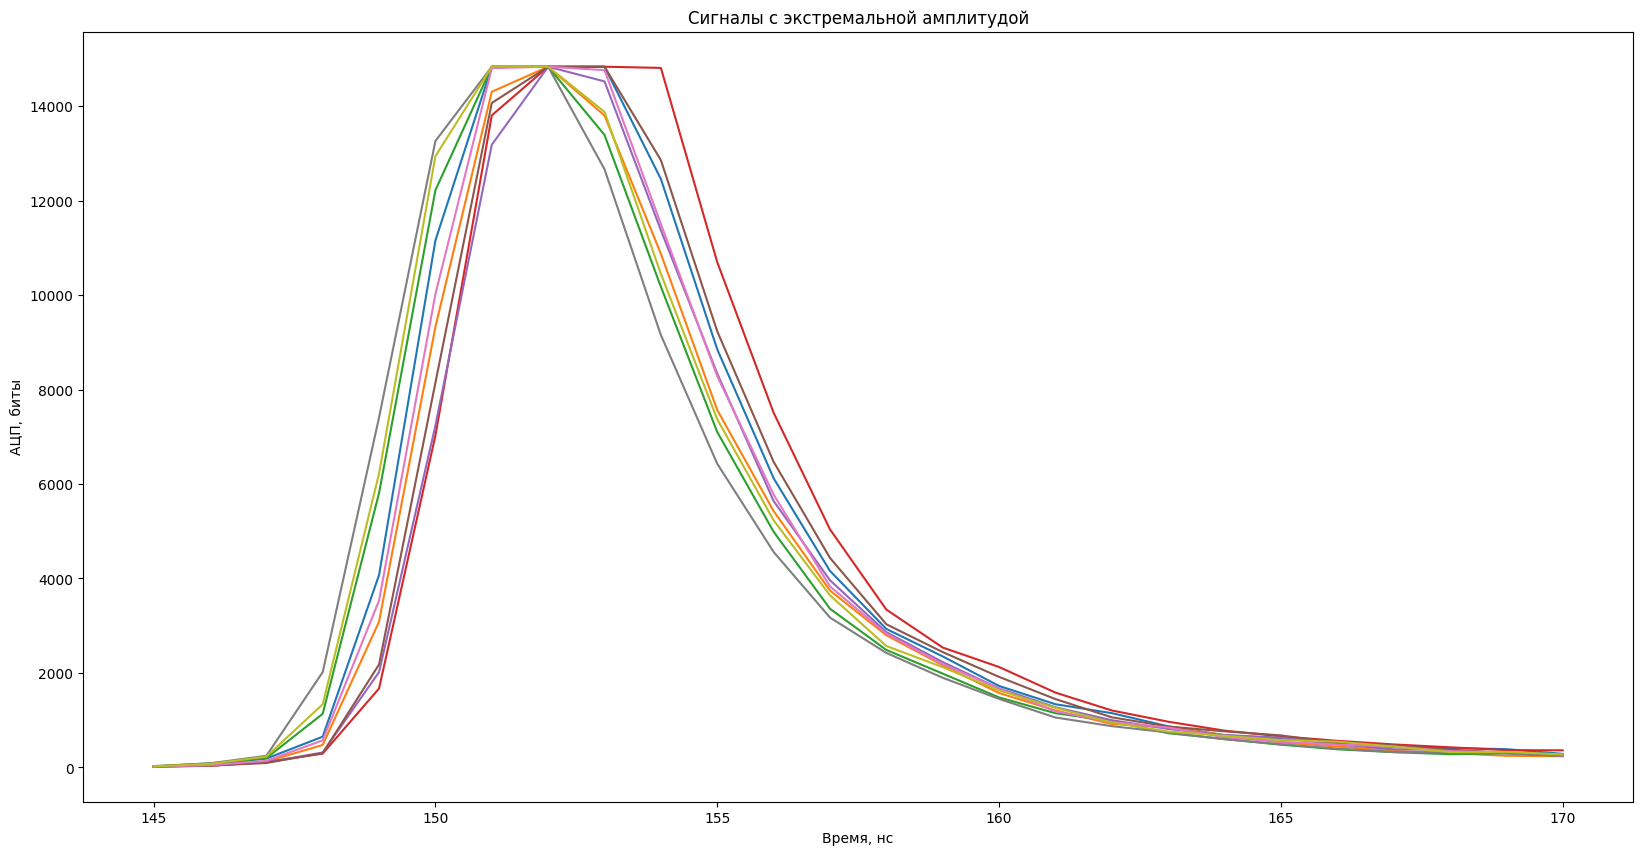

In [75]:
# Извлекаем индексы записей с максимальной амплитудой
peak_indices = peak_samples.index.tolist()

# Строим график значимой области для отобранных записей
plot = peak_samples.T.loc[145:170].plot(
    title='Сигналы с экстремальной амплитудой',
    legend=None,
    figsize=(20, 10)
)

plot.set_xlabel("Время, нс")
plot.set_ylabel("АЦП, биты")


Значение 14 834 держится на одном уровне, образуя заметное плато.

Значит, мы уперлись либо в чувствительность АЦП, либо достигли верхнего предела динамического диапазона оборудования.

При финальной кластеризации такие точки попадут в Класс 2(аппаратные шумы и артефакты насыщения).

In [76]:
print("Первые записи набора данных:")
analysis_data.head()

Первые записи набора данных:


0   1   2   3   4   5   6   7   8   9  ...  491  492  493  494  495  496  \
0  14  11  10  12  16  14  10  12  14  14  ...   12   19   19   17   15   14   
1  14  12  14   8  10  12  14  12  11  13  ...   17   10   12   10   15   14   
2  14  14  12   9  14  10  10  15  11  10  ...   13   14   14   16   13   11   
3   6  12  16  10  10  12  14  12  10  14  ...    8   12   13   14    6   14   
4  11  19  11  13   7  14  11  10  18  13  ...   14   11    6   10   14   10   

   497  498  499  peak_value  
0   12   14   15         543  
1   15   12   14        1913  
2   14   14   13        2570  
3   12   11   12         576  
4   10   12    9        1806  

[5 rows x 501 columns]

Поиск многоимпульсных сигналов в данных

In [77]:
def detect_peaks(signal, min_height=100, min_interval=100):
    """Обнаруживает пики в сигнале с заданными параметрами"""
    peak_indices, _ = find_peaks(
        signal,
        height=min_height,
        distance=min_interval
    )
    return len(peak_indices)

# Анализируем каждую запись на наличие множественных пиков
peak_counts = processed_data.apply(detect_peaks, axis=1)

# Выбираем записи с более чем одним пиком
multi_peak_signals = peak_counts[peak_counts > 1]
multi_peak_ids = multi_peak_signals.index.tolist()

print(f"Обнаружено {len(multi_peak_ids)} сигналов с множественными пиками")

Обнаружено 2 сигналов с множественными пиками


Визуализация сигналов с множественными пиками

Визуализировано 2 многоимпульсных сигналов:


<Figure size 2000x1000 with 0 Axes>

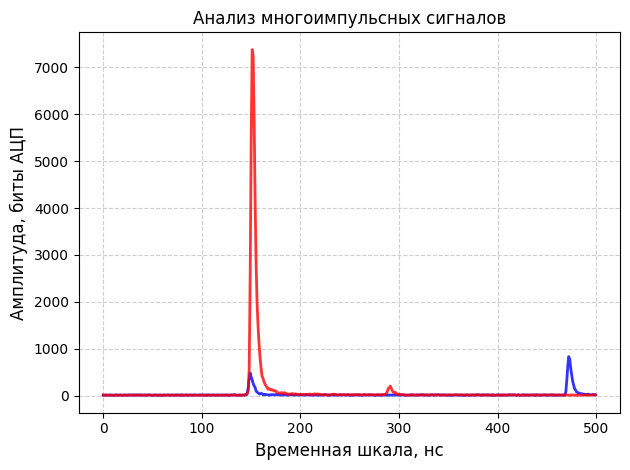

In [78]:
# Визуализация сигналов с множественными пиками
plt.figure(figsize=(20, 10))
signal_plot = processed_data.T.loc[:, multi_peak_ids].plot(
    title='Анализ многоимпульсных сигналов',
    legend=None,
    color=['blue', 'red'],  # Разные цвета для каждого сигнала
    linewidth=2,
    alpha=0.8
)

# Настройка оформления графика
signal_plot.set_xlabel("Временная шкала, нс", fontsize=12)
signal_plot.set_ylabel("Амплитуда, биты АЦП", fontsize=12)
signal_plot.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

print(f"Визуализировано {len(multi_peak_ids)} многоимпульсных сигналов:")

Анализ выявил сигналы с множественными пиками, которые будут отнесены к шумовым (класс 2). Дополнительно вычислим размах колебаний для каждого сигнала, характеризующий его динамические свойства.

In [79]:
# Классификация многоимпульсных сигналов как шумов (класс 2)
analysis_data.loc[multi_peak_ids, 'signal_class'] = 2

# Расчет амплитуды колебаний для каждого сигнала:
# Разница между пиковым и минимальным значениями
analysis_data['oscillation_amplitude'] = (
    analysis_data['peak_value'] -
    analysis_data.iloc[:, :-2].min(axis=1)  # Исключаем peak_amplitude и signal_class
)

# Анализ распределения амплитуд
print("Статистика амплитуд колебаний:")
analysis_data['oscillation_amplitude'].describe()

Статистика амплитуд колебаний:


count    23479.000000
mean      1842.849568
std       2389.075855
min        113.000000
25%        316.000000
50%        820.000000
75%       2322.500000
max      14833.000000
Name: oscillation_amplitude, dtype: float64

In [80]:
# Выводим первые 5 записей для проверки структуры данных
print("Первые 5 записей обработанного датасета:")
analysis_data.head()

Первые 5 записей обработанного датасета:


0   1   2   3   4   5   6   7   8   9  ...  493  494  495  496  497  498  \
0  14  11  10  12  16  14  10  12  14  14  ...   19   17   15   14   12   14   
1  14  12  14   8  10  12  14  12  11  13  ...   12   10   15   14   15   12   
2  14  14  12   9  14  10  10  15  11  10  ...   14   16   13   11   14   14   
3   6  12  16  10  10  12  14  12  10  14  ...   13   14    6   14   12   11   
4  11  19  11  13   7  14  11  10  18  13  ...    6   10   14   10   10   12   

   499  peak_value  signal_class  oscillation_amplitude  
0   15         543           NaN                    539  
1   14        1913           NaN                   1907  
2   13        2570           NaN                   2566  
3   12         576           NaN                    573  
4    9        1806           NaN                   1800  

[5 rows x 503 columns]

Характеристику скорости затухания будем оценивать через площадь под кривой сигнала. В условиях равномерной временной сетки (постоянного шага измерений) эта величина вычисляется как сумма отсчетов в каждой временной реализации.

In [81]:
# Вычисление площади под кривой сигнала (сумма значений)
analysis_data['signal_area'] = analysis_data.iloc[:, :-3].sum(axis=1)  # Исключаем последние 3 служебных столбца

# Проверка первых записей с новым признаком
print("Датасет с рассчитанной площадью сигналов:")
analysis_data[['peak_value', 'oscillation_amplitude', 'signal_area']].head()

Датасет с рассчитанной площадью сигналов:


peak_value  oscillation_amplitude  signal_area
0         543                    539        11049
1        1913                   1907        18113
2        2570                   2566        22995
3         576                    573        10278
4        1806                   1800        17891

Построим распределения двух ключевых параметров:    
    Амплитуды колебаний (размах между максимумом и минимумом)
    Площади под кривой (интегральная характеристика сигнала)

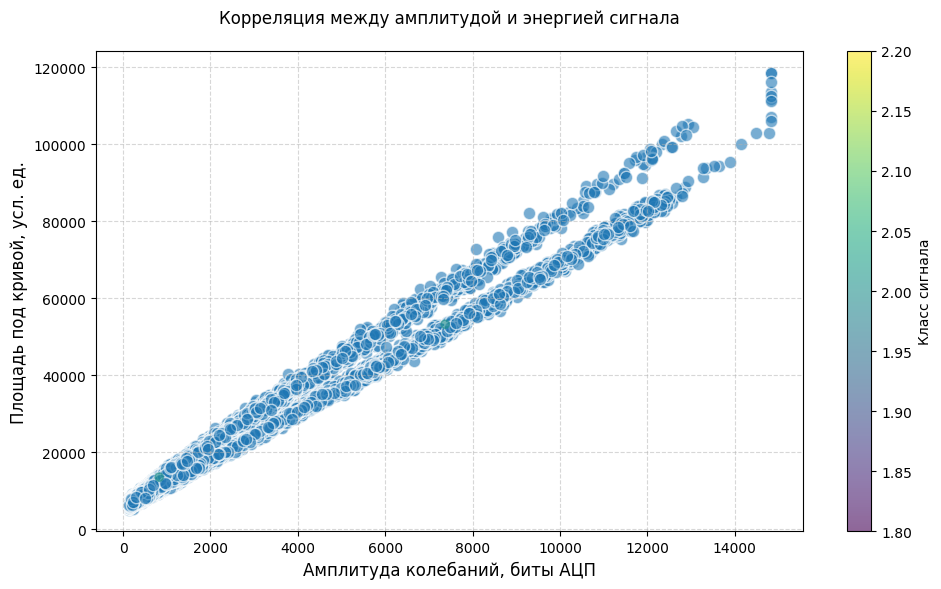

In [82]:
# Строим диаграмму рассеяния для анализа взаимосвязи параметров
plt.figure(figsize=(10, 6))
plt.scatter(
    analysis_data['oscillation_amplitude'],
    analysis_data['signal_area'],
    alpha=0.6,
    edgecolors='w',
    s=80
)

# Настраиваем оформление графика
plt.xlabel('Амплитуда колебаний, биты АЦП', fontsize=12)
plt.ylabel('Площадь под кривой, усл. ед.', fontsize=12)
plt.title('Корреляция между амплитудой и энергией сигнала', pad=20)
plt.grid(True, linestyle='--', alpha=0.5)

# Добавляем цветовую маркировку по классам (если есть)
if 'signal_class' in analysis_data.columns:
    sc = plt.scatter(
        analysis_data['oscillation_amplitude'],
        analysis_data['signal_area'],
        c=analysis_data['signal_class'],
        cmap='viridis',
        alpha=0.6
    )
    plt.colorbar(sc, label='Класс сигнала')

plt.tight_layout()
plt.show()

На диаграмме рассеяния четко просматривается разделение данных на два обособленных класса

In [83]:
# Формируем матрицу признаков для кластеризации
cluster_features = analysis_data[['oscillation_amplitude', 'signal_area']].copy()

# Проверяем первые 5 записей
print("Матрица признаков для кластеризации:")
print(cluster_features.head())

Матрица признаков для кластеризации:
   oscillation_amplitude  signal_area
0                    539        11049
1                   1907        18113
2                   2566        22995
3                    573        10278
4                   1800        17891


Т.к.в дальнейшем применим PCA, проведем стандартизацию данных

In [84]:
# Подгоняем все признаки под общий масштаб
from sklearn.preprocessing import StandardScaler

# Создаём стандартный скейлер
feature_scaler = StandardScaler()

# Применяем масштабирование и получаем уже нормализованные данные
normalized_features = feature_scaler.fit_transform(cluster_features)

# Взглянем на первые пять строк результата
print("Первые 5 нормализованных образцов:")
print(normalized_features[:5])

Первые 5 нормализованных образцов:
[[-0.5457664  -0.4724829 ]
 [ 0.02685214 -0.03384989]
 [ 0.30269689  0.26929371]
 [-0.53153466 -0.52035748]
 [-0.01793601 -0.04763479]]


Выделим главные компоненты методом PCA

In [85]:
# Ужимаем данные до двух признаков через PCA (будет проще визуализировать)
from sklearn.decomposition import PCA
dimension_reducer = PCA(n_components=2)

# Прогоняем нормализованные данные через PCA
reduced_features = dimension_reducer.fit_transform(normalized_features)

# Смотрим, что получилось
print("Результат PCA:")
print(f"- Доля объяснённой дисперсии по компонентам: {dimension_reducer.explained_variance_ratio_}")
print(f"- Суммарно объяснено: {sum(dimension_reducer.explained_variance_ratio_):.2f}")
print("\nПервые 5 точек в новом пространстве:")
print(reduced_features[:5])


Результат PCA:
- Доля объяснённой дисперсии по компонентам: [0.99503368 0.00496632]
- Суммарно объяснено: 1.00

Первые 5 точек в новом пространстве:
[[-0.72001099  0.05181926]
 [-0.00494816 -0.04292282]
 [ 0.40445843 -0.02361962]
 [-0.74380006  0.00790345]
 [-0.04636555 -0.02100021]]


Визуализируем значение компонент

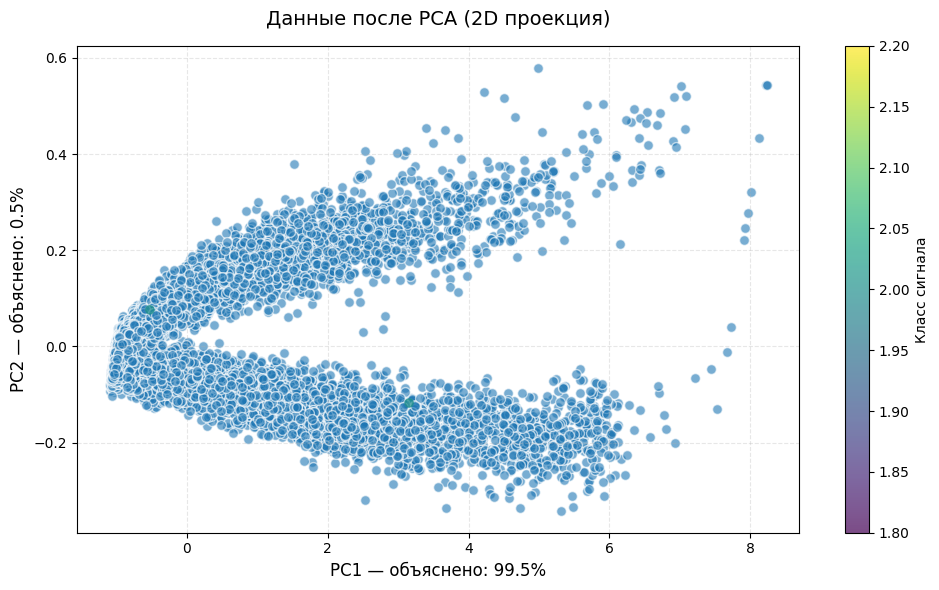

In [86]:
# Рисуем результат PCA
plt.figure(figsize=(10, 6))
plt.scatter(
    reduced_features[:, 0],  # Ось X - первая главная компонента
    reduced_features[:, 1],  # Ось Y - вторая главная компонента
    alpha=0.6,               # Прозрачность, чтобы точки не сливались
    edgecolor='w',           # Белая окантовка точек
    s=50                     # Размер кружков
)

# Подписи и оформление
plt.title('Данные после PCA (2D проекция)', pad=15, fontsize=14)
plt.xlabel(f'PC1 — объяснено: {dimension_reducer.explained_variance_ratio_[0]:.1%}', fontsize=12)
plt.ylabel(f'PC2 — объяснено: {dimension_reducer.explained_variance_ratio_[1]:.1%}', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# Если в данных есть информация о классах - подсветим их разным цветом
if 'signal_class' in analysis_data.columns:
    plt.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        c=analysis_data['signal_class'],
        cmap='viridis',
        alpha=0.7
    )
    plt.colorbar(label='Класс сигнала')

plt.tight_layout()
plt.show()

Разделение на кластеры визуально стало четче.
Попробуем применить KMeans для разбиения на кластеры

In [87]:
# Запускаем K-means:
# - 2 кластера (судя по графику PCA)
# - 100 инициализаций для надёжности
# - фиксируем random_state, чтобы результат можно было повторить
cluster_analyzer = KMeans(
    n_clusters=2,
    n_init=100,
    random_state=42
)

# Обучаем модель на наших данных и сразу получаем метки кластеров
cluster_labels = cluster_analyzer.fit_predict(reduced_features)

# Выводим результат
print("Результаты кластеризации:")
print(f"Координаты центров кластеров:\n{cluster_analyzer.cluster_centers_}")
print(f"Метки для первых 10 точек: {cluster_labels[:10]}")
print(f"Инерция (сумма квадратов внутри кластеров): {cluster_analyzer.inertia_:.2f}")


Результаты кластеризации:
Координаты центров кластеров:
[[ 2.71883774e+00 -7.24180510e-03]
 [-5.27645060e-01  1.40541770e-03]]
Метки для первых 10 точек: [1 1 1 1 1 1 1 1 1 1]
Инерция (сумма квадратов внутри кластеров): 13275.18


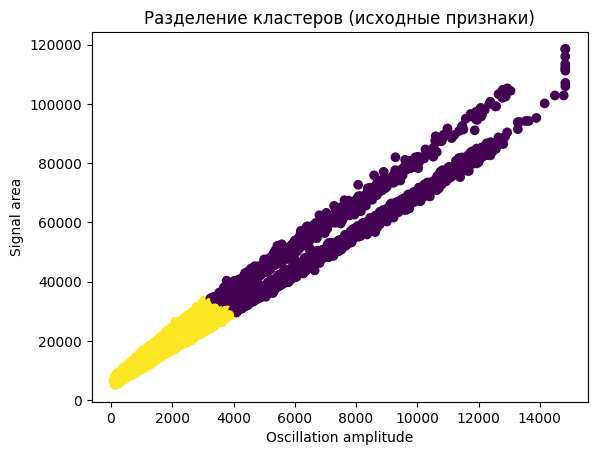

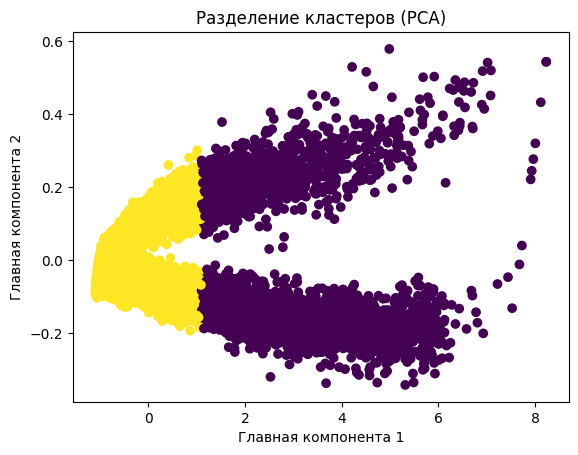

In [88]:
# Смотрим, как разлетелись кластеры в исходных признаках
plt.scatter(
    analysis_data['oscillation_amplitude'],
    analysis_data['signal_area'],
    c=cluster_labels
)
plt.xlabel('Oscillation amplitude')
plt.ylabel('Signal area')
plt.title('Разделение кластеров (исходные признаки)')
plt.show()

# А теперь проверим, как это выглядит в пространстве PCA
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=cluster_labels
)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('Разделение кластеров (PCA)')
plt.show()


KMean не справляется с таким разделением.

Попробуем агломеративную кластеризацию.

Сколько точек в каждом кластере:
0    20439
1     3040
Name: count, dtype: int64


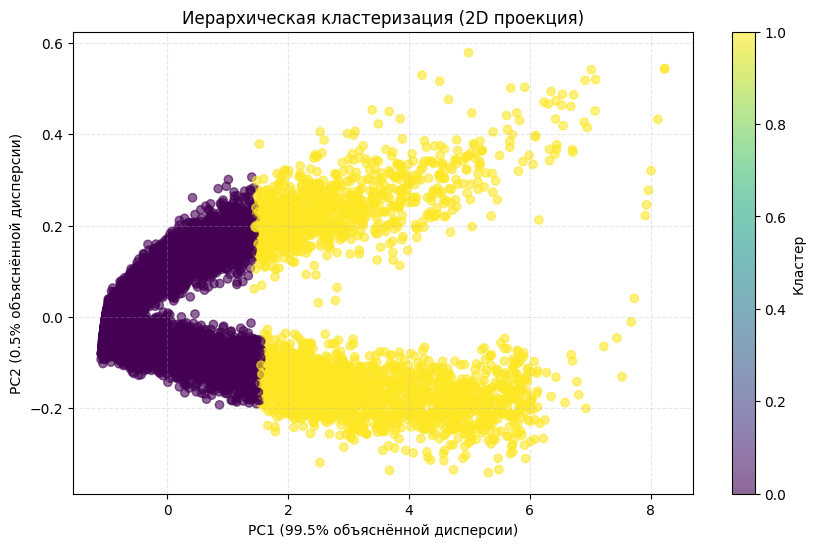

In [89]:
# Создаём модель и сразу обучаем её на сжатых данных PCA
hierarchical_clusterer = AgglomerativeClustering(n_clusters=2)
hierarchical_clusterer.fit(reduced_features)

# Забираем метки кластеров
hierarchical_labels = hierarchical_clusterer.labels_

# Проверим, как точки распределились между кластерами
print("Сколько точек в каждом кластере:")
print(pd.Series(hierarchical_labels).value_counts())

# Визуализируем результат в PCA-пространстве
plt.figure(figsize=(10, 6))
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=hierarchical_labels,
    cmap='viridis',
    alpha=0.6
)
plt.title('Иерархическая кластеризация (2D проекция)')
plt.xlabel(f'PC1 ({dimension_reducer.explained_variance_ratio_[0]:.1%} объяснённой дисперсии)')
plt.ylabel(f'PC2 ({dimension_reducer.explained_variance_ratio_[1]:.1%} объяснённой дисперсии)')
plt.colorbar(label='Кластер')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


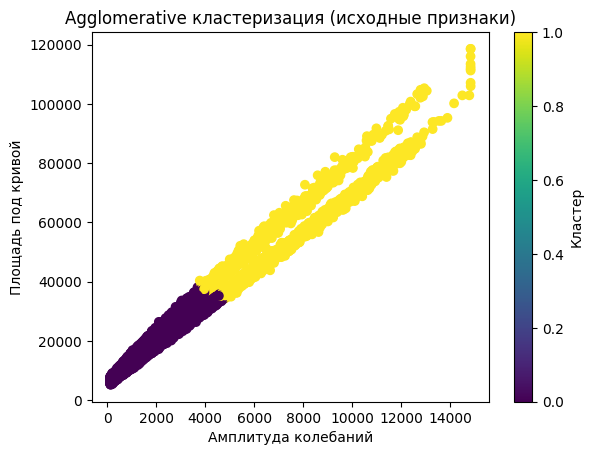

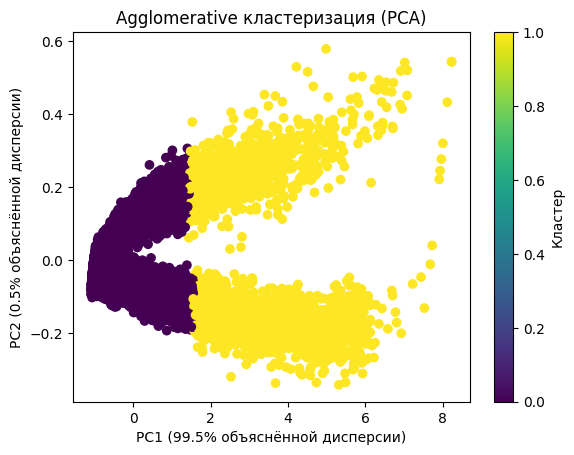

In [90]:
# Визуализация результатов Agglomerative кластеризации

# Разделение кластеров в исходных признаках (амплитуда/площадь)
plt.scatter(
    analysis_data['oscillation_amplitude'],
    analysis_data['signal_area'],
    c=hierarchical_labels
)
plt.xlabel('Амплитуда колебаний')
plt.ylabel('Площадь под кривой')
plt.title('Agglomerative кластеризация (исходные признаки)')
plt.colorbar(label='Кластер')
plt.show()

# То же, но в пространстве PCA - удобнее видеть разрывы между кластерами
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=hierarchical_labels
)
plt.xlabel(f'PC1 ({dimension_reducer.explained_variance_ratio_[0]:.1%} объяснённой дисперсии)')
plt.ylabel(f'PC2 ({dimension_reducer.explained_variance_ratio_[1]:.1%} объяснённой дисперсии)')
plt.title('Agglomerative кластеризация (PCA)')
plt.colorbar(label='Кластер')
plt.show()

Эта модель также не справилась.
Попробуем DBSCAN с разными гиперпараметрами.

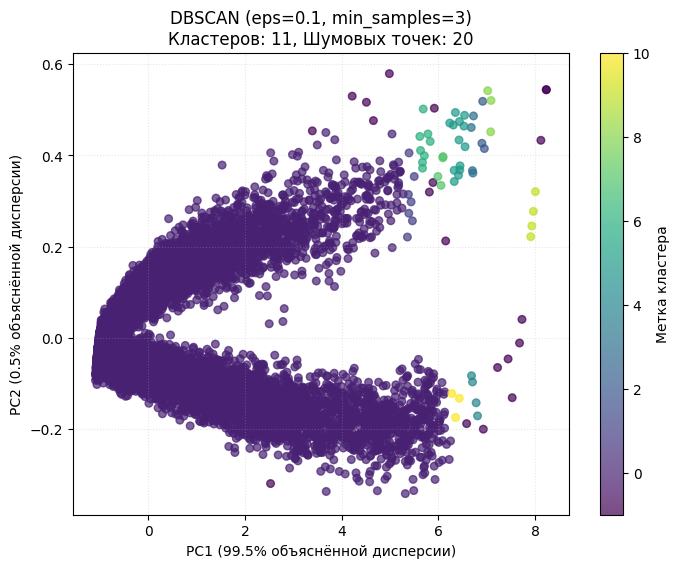

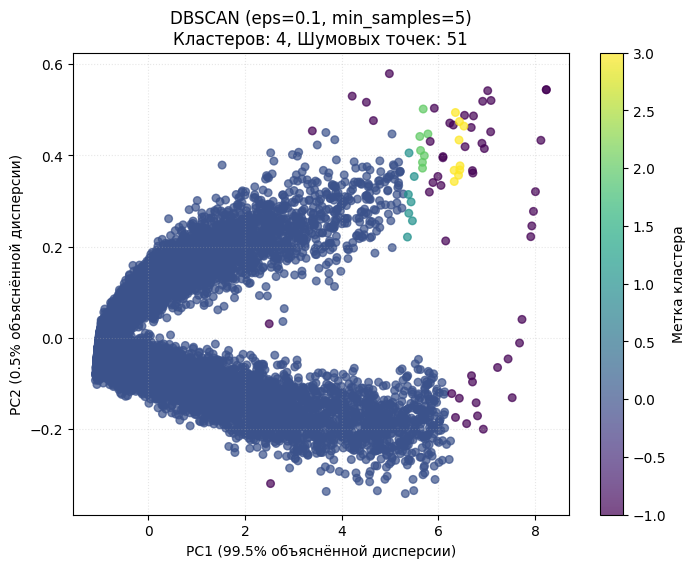

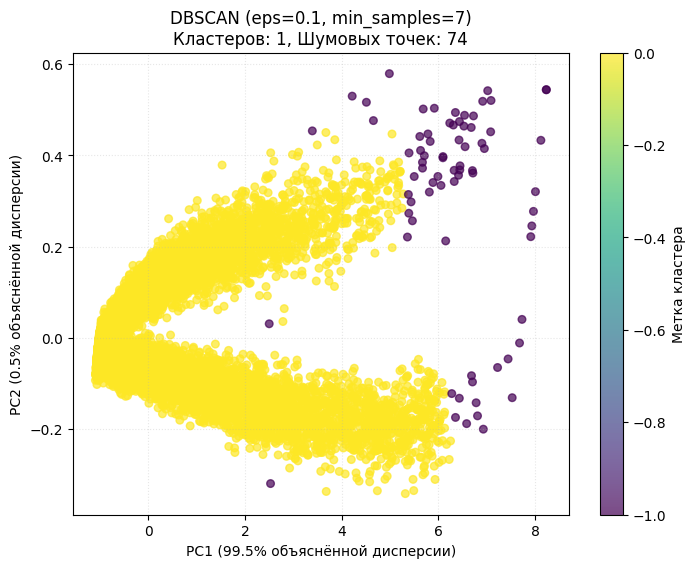

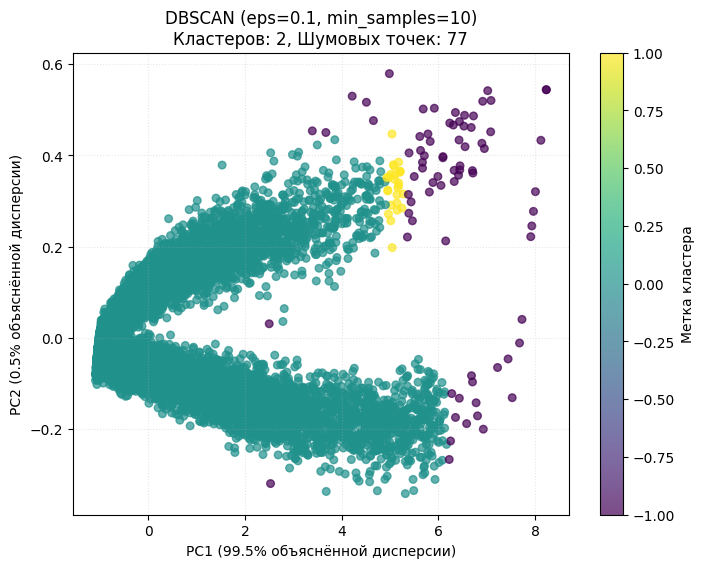

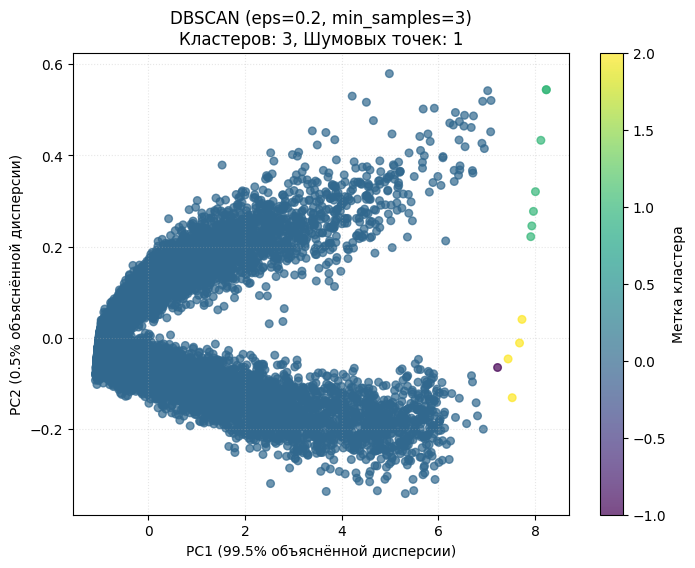

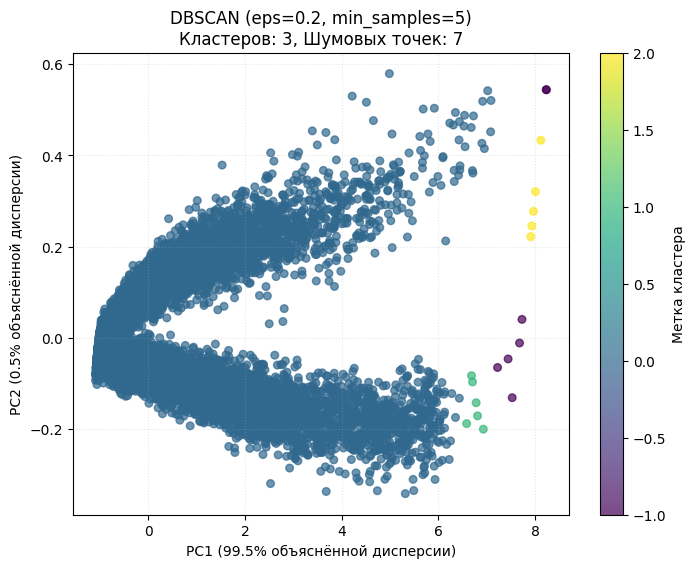

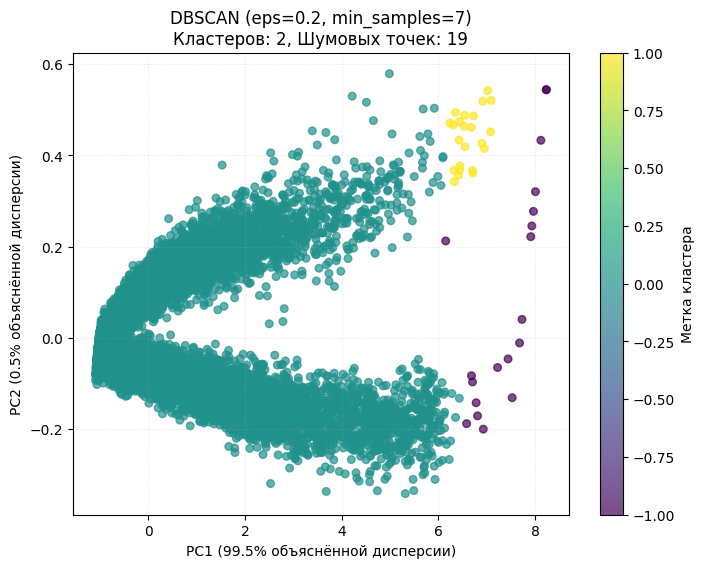

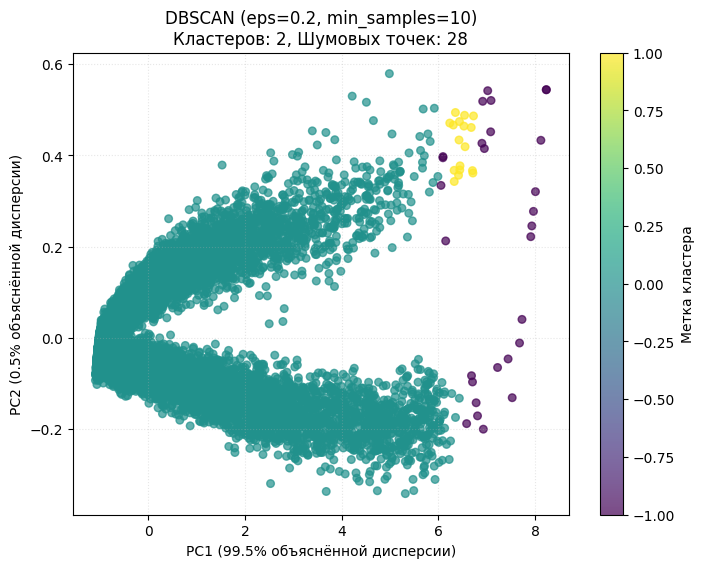

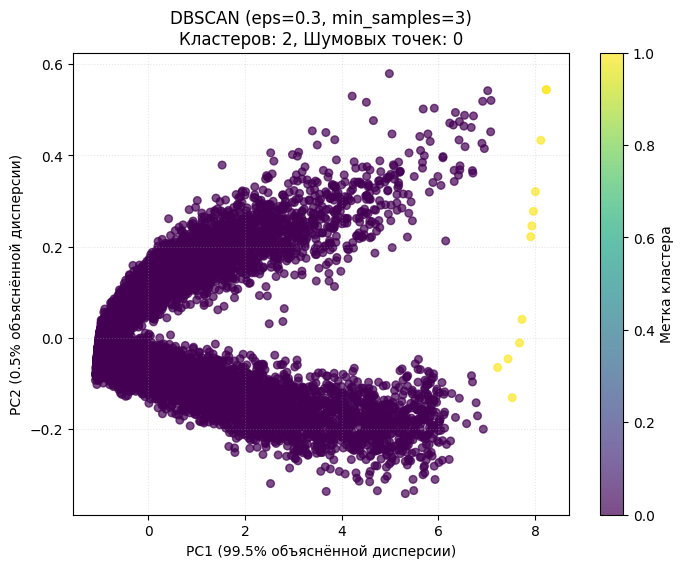

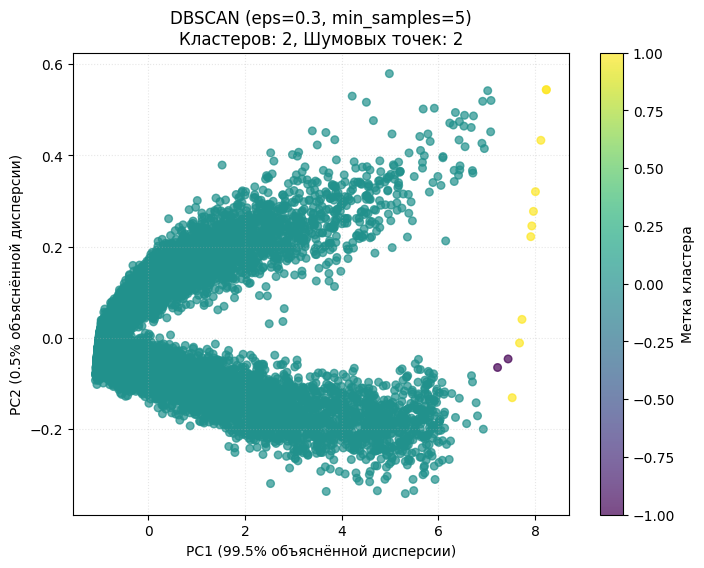

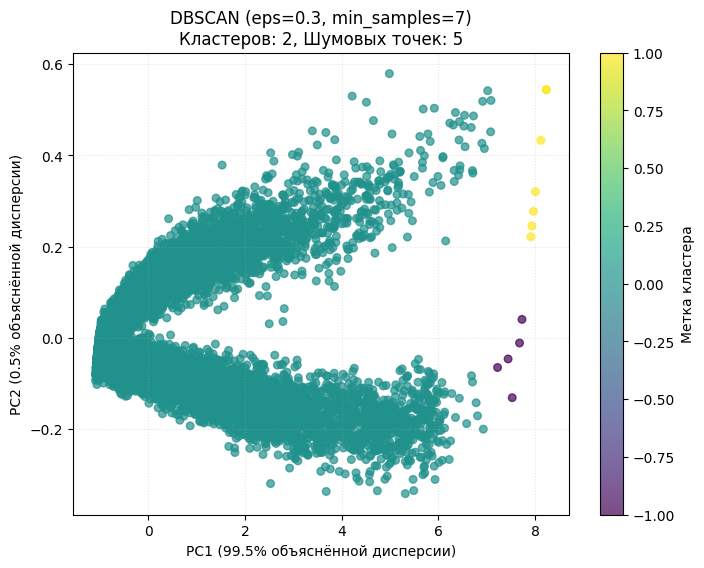

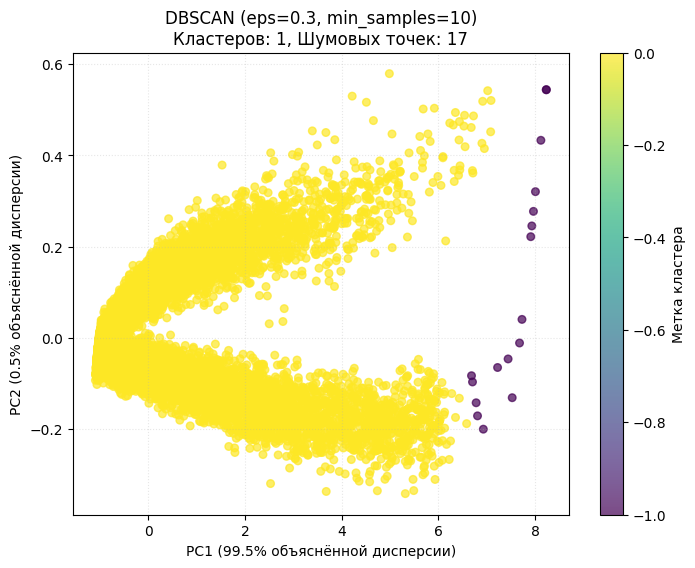

In [91]:
# Пробуем разные параметры для DBSCAN, чтобы понять, как алгоритм делит данные
eps_values = [0.1, 0.2, 0.3]
min_samples_values = [3, 5, 7, 10]

for eps in eps_values:
    for min_samples in min_samples_values:
        # Создаём модель с текущими параметрами и обучаем
        dbscan_clusterer = DBSCAN(eps=eps, min_samples=min_samples).fit(reduced_features)
        cluster_labels = dbscan_clusterer.labels_

        # Считаем, сколько получилось кластеров и сколько шумовых точек
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)

        # Визуализируем результаты в PCA-пространстве
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            reduced_features[:, 0],
            reduced_features[:, 1],
            c=cluster_labels,
            cmap='viridis',
            alpha=0.7,
            s=30
        )

        plt.title(
            f'DBSCAN (eps={eps}, min_samples={min_samples})\n'
            f'Кластеров: {n_clusters}, Шумовых точек: {n_noise}'
        )
        plt.xlabel(f'PC1 ({dimension_reducer.explained_variance_ratio_[0]:.1%} объяснённой дисперсии)')
        plt.ylabel(f'PC2 ({dimension_reducer.explained_variance_ratio_[1]:.1%} объяснённой дисперсии)')
        plt.colorbar(scatter, label='Метка кластера')
        plt.grid(True, linestyle=':', alpha=0.3)
        plt.show()


DBSCAN также не справился с такой структурой, поэтому проверим GaussianMixture

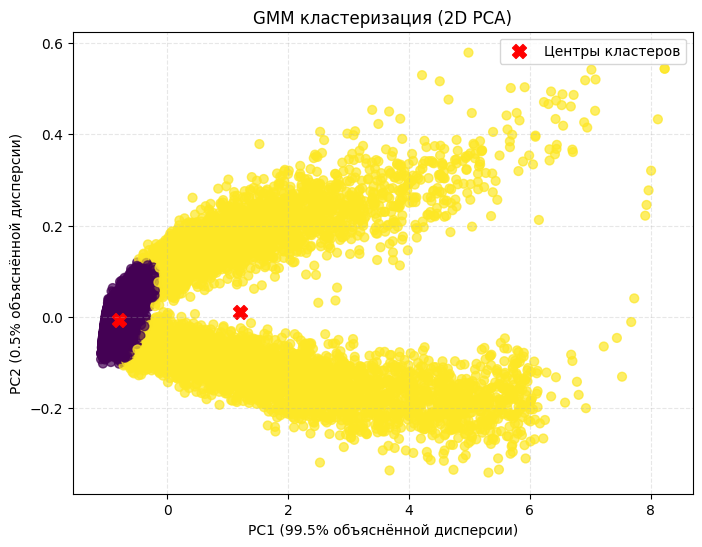

In [92]:
# Кластеризация с помощью Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42).fit(reduced_features)
gmm_labels = gmm.predict(reduced_features)

# Визуализируем результат
plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=gmm_labels,
    cmap='viridis',
    alpha=0.7,
    s=40
)

# Показываем центры кластеров на графике
plt.scatter(
    gmm.means_[:, 0],
    gmm.means_[:, 1],
    marker='X',
    s=100,
    c='red',
    label='Центры кластеров'
)

plt.title('GMM кластеризация (2D PCA)')
plt.xlabel(f'PC1 ({dimension_reducer.explained_variance_ratio_[0]:.1%} объяснённой дисперсии)')
plt.ylabel(f'PC2 ({dimension_reducer.explained_variance_ratio_[1]:.1%} объяснённой дисперсии)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

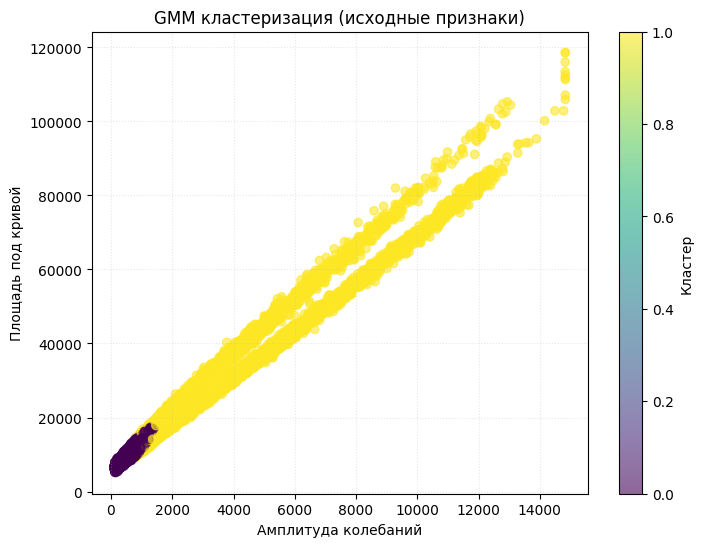

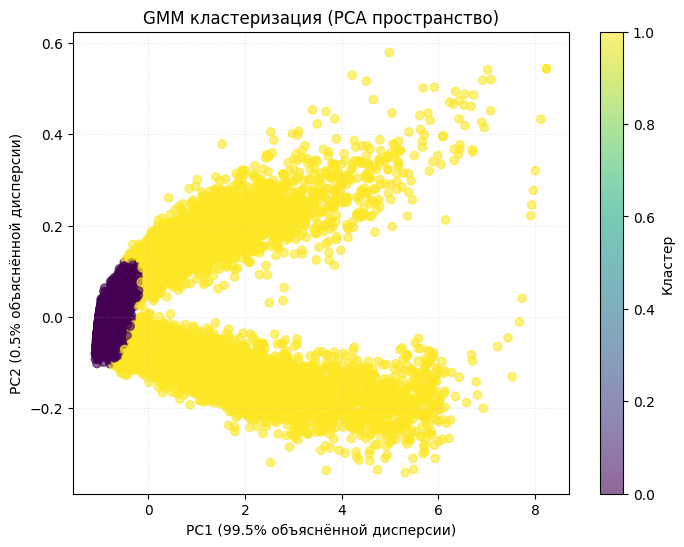

In [93]:
# Визуализация результатов GMM кластеризации

# Кластеры в исходном пространстве признаков
plt.figure(figsize=(8, 6))
plt.scatter(
    analysis_data['oscillation_amplitude'],
    analysis_data['signal_area'],
    c=gmm_labels,
    cmap='viridis',
    alpha=0.6
)
plt.xlabel('Амплитуда колебаний')
plt.ylabel('Площадь под кривой')
plt.title('GMM кластеризация (исходные признаки)')
plt.colorbar(label='Кластер')
plt.grid(True, linestyle=':', alpha=0.3)
plt.show()

# Кластеры в пространстве PCA
plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=gmm_labels,
    cmap='viridis',
    alpha=0.6
)
plt.xlabel(f'PC1 ({dimension_reducer.explained_variance_ratio_[0]:.1%} объяснённой дисперсии)')
plt.ylabel(f'PC2 ({dimension_reducer.explained_variance_ratio_[1]:.1%} объяснённой дисперсии)')
plt.title('GMM кластеризация (PCA пространство)')
plt.colorbar(label='Кластер')
plt.grid(True, linestyle=':', alpha=0.3)
plt.show()


После проверки разных настроек для всех моделей кластеризации стало ясно, что ни одна из них не даёт точного разделения данных. Если взглянуть на график проекции на главные компоненты, видно, что наиболее простое и логичное разделение может быть реализовано линейным разделителем — вертикальной линией примерно на уровне второй компоненты ≈ -0.015.

In [94]:
# Ручное разделение на кластеры с использованием порога по второй главной компоненте
threshold = -0.015

# Инициализируем массив меток кластеров (по умолчанию все в кластер 1)
cluster_labels = np.ones(len(reduced_features), dtype=int)

# Разделяем точки. Если значение PC2 выше порога - переносим в кластер 0
cluster_labels[reduced_features[:, 1] > threshold] = 0

# Дополнительно можно пометить шумовые данные (например, экстремальные значения или множественные пики)
over_max_idx = 2       # пример индекса для сигнала выше допустимого максимума
multi_peak_idx = 2     # пример индекса для сигналов с несколькими пиками

# Смотрим распределение точек по кластерам
print("Распределение по кластерам:")
print(pd.Series(cluster_labels).value_counts().sort_index())

Распределение по кластерам:
0    11077
1    12402
Name: count, dtype: int64


Визуализируем, получившееся ручное разделение

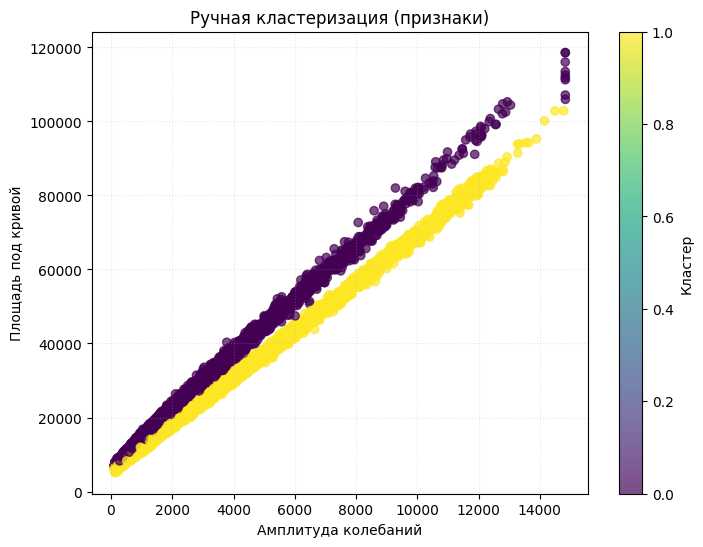

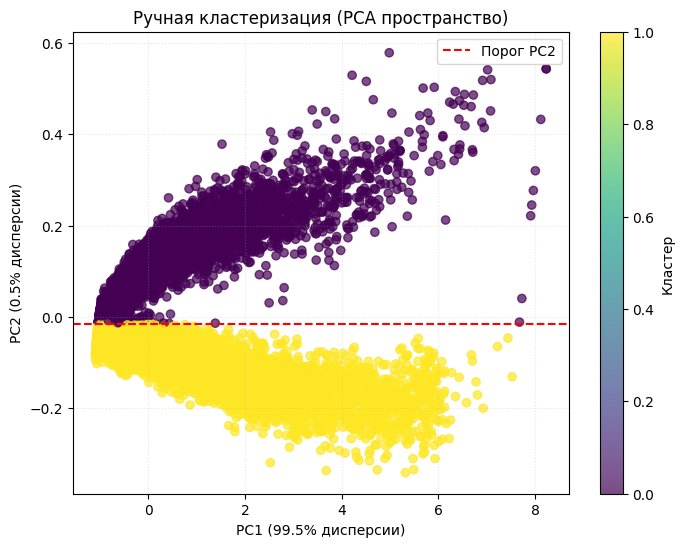

In [95]:
# Визуализация ручного разделения на кластеры

# 1. Кластеры в исходном пространстве признаков (амплитуда vs площадь)
plt.figure(figsize=(8, 6))
plt.scatter(
    analysis_data['oscillation_amplitude'],
    analysis_data['signal_area'],
    c=cluster_labels,
    cmap='viridis',
    alpha=0.7
)
plt.xlabel('Амплитуда колебаний')
plt.ylabel('Площадь под кривой')
plt.title('Ручная кластеризация (признаки)')
plt.colorbar(label='Кластер')
plt.grid(True, linestyle=':', alpha=0.3)
plt.show()

# 2. Кластеры в пространстве PCA
plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=cluster_labels,
    cmap='viridis',
    alpha=0.7
)
# Добавляем горизонтальную линию — границу между кластерами
plt.axhline(y=-0.015, color='red', linestyle='--', label='Порог PC2')
plt.xlabel(f'PC1 ({dimension_reducer.explained_variance_ratio_[0]:.1%} дисперсии)')
plt.ylabel(f'PC2 ({dimension_reducer.explained_variance_ratio_[1]:.1%} дисперсии)')
plt.title('Ручная кластеризация (PCA пространство)')
plt.colorbar(label='Кластер')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.3)
plt.show()


Как видим получилось довольно точное разделение.
Проверим начало массива классов

In [96]:
cluster_labels[:10]

array([0, 1, 1, 0, 1, 0, 0, 1, 1, 0])

Видим, что нам нужно инвертировать 0 и 1. Сделаем это и сохраним в файл

In [97]:
# Меняем местами метки кластеров (0 <-> 1), если нужно
inverted_labels = np.where(
    (cluster_labels == 0) | (cluster_labels == 1),
    1 - cluster_labels,
    cluster_labels
)

# Формируем DataFrame для экспорта
submission_df = pd.DataFrame({
    'index': np.arange(len(inverted_labels)),  # порядковые номера записей
    'cluster': inverted_labels                 # метки кластеров
})

# Проверяем распределение по кластерам перед сохранением
print("Распределение кластеров для сохранения:")
print(submission_df['cluster'].value_counts().sort_index())

# Сохраняем результаты в CSV
submission_df.to_csv('submission.csv', index=False)
print("\nФайл 'submission.csv' успешно сохранён")

Распределение кластеров для сохранения:
cluster
0    12402
1    11077
Name: count, dtype: int64

Файл 'submission.csv' успешно сохранён
